Import packages and functions

In [19]:
import sys
sys.path.append('../../')


from scripts.forecast import DataGenerator, make_photoz_bin_edges, compare_fisher_matrices
from scripts.luminosity_functions import def_agn_xlf
from scripts.utils import path2res_forecast
%matplotlib inline


In [12]:


fiducial_params = {'Omega_c': 0.25, 'Omega_b': 0.05,
                   'h': 0.7, 'sigma8': 0.8, 'n_s': 0.96,
                   'transfer_function': 'boltzmann_camb',
                   'baryons_power_spectrum': 'nobaryons',
                   'matter_power_spectrum': 'linear'}

fsky = 0.658
powspec_pars_dict_agn = {
    'slim': 1e-14,
    'sigma_0': 0.03,
    'f_fail': 0.1,
    'l_min': 10,
    'l_max': 500,
    'log_bins': 41,
    'fsky': fsky,
    'has_rsd': True,
    'use_weighed_bias': False,
    'density_multiplier': 1.3,
    'camb_llimber': 110,
    'xlf': def_agn_xlf,
    'use_camb': True,
    'delta_i': 3,
    'remove_ignored_cells': True,
}

SETNAME = 'mcmc_test_agn'


zmin_agn = 0.5
zmax_agn = 2.5
k_photoz_agn = 1


bin_left_edges = make_photoz_bin_edges(
    zmin_agn, zmax_agn, k=k_photoz_agn, sigma_0=powspec_pars_dict_agn['sigma_0'])
powspec_pars_dict_agn['bin_left_edges'] = bin_left_edges


Total AGN sources: 1914915 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.03, self.f_fail=0.1
calculating CAMB...
CAMB calculation time: 1.8558480739593506


calc Covariance: 100%|██████████| 435/435 [00:01<00:00, 256.22it/s]


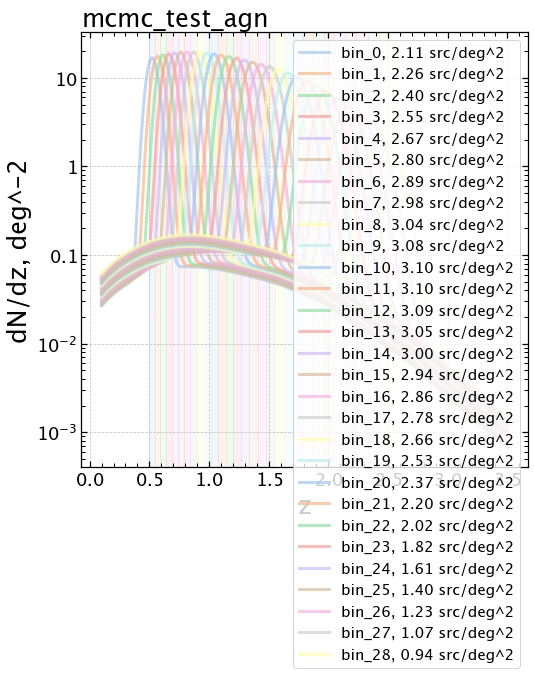

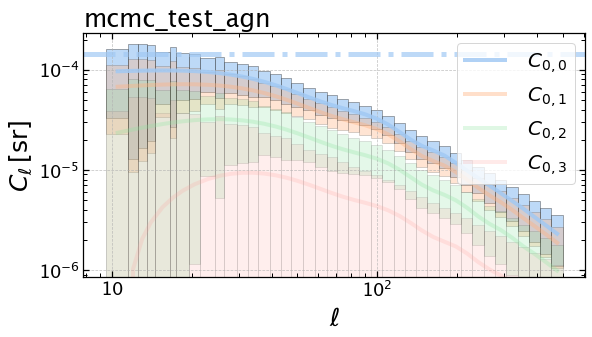

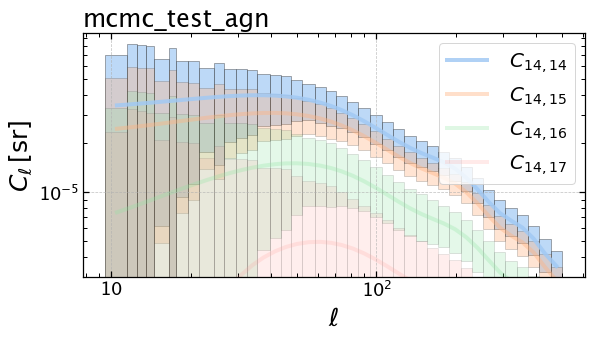

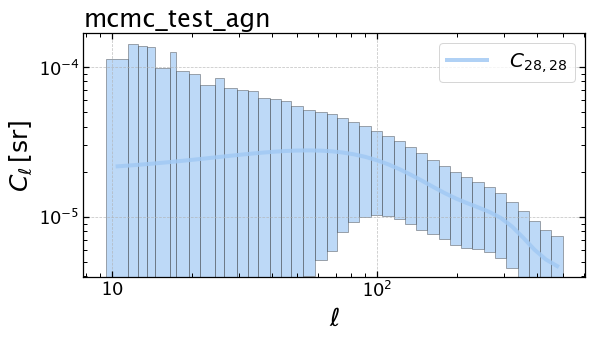

In [13]:
datagen = DataGenerator(fiducial_params=fiducial_params, set_name=SETNAME,)

datagen.invoke(
    **powspec_pars_dict_agn, plot_cell=True, plot_dndz=True)


Start Jacobian calculation (cosmological part): jac_step=0.0005, jac_order=2
Finished Jacobian calculation (cosmological part) in 31.43 seconds

mcmc_test_agn h prior (0.1) n_s prior (0.01)
FoM: 1.14e+11
Omega_c: 0.250 +- 0.017 (7.0 %)
Omega_b: 0.050 +- 0.007 (13.4 %)
h: 0.700 +- 0.059 (8.5 %)
n_s: 0.960 +- 0.010 (1.0 %)
sigma_8: 0.800 +- 0.004 (0.5 %)
-------


(<Figure size 720x720 with 25 Axes>,
                                              $\Omega_c$ $\Omega_b$   $h$  \
 mcmc_test_agn h prior (0.1) n_s prior (0.01)       7.0%      13.4%  8.5%   
 
                                              $n_s$ $\sigma_8$    FoM  
 mcmc_test_agn h prior (0.1) n_s prior (0.01)  1.0%       0.5%  11.06  )

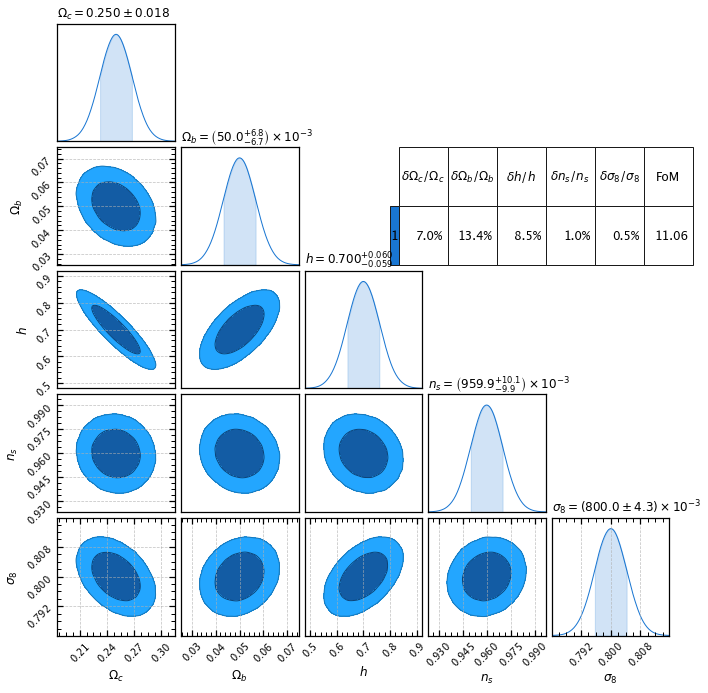

In [14]:

F_prior = datagen.get_Fisher_matrix()[0].add_prior_by_idx(2, 0.1).add_prior_by_idx(3, 0.01)
compare_fisher_matrices([F_prior])

In [31]:
from scripts.forecast import make_cobaya_input
fix_cov=True
make_cobaya_input(datagen, foldername=SETNAME, F =F_prior, fix_cov=fix_cov )

In [32]:
from cobaya.model import get_model
from scripts.forecast import gaussian_loglike

model_fiducial = get_model(
        f'{path2res_forecast}/mcmc/{datagen.set_name}/info_auto.yaml')  # type: ignore

point = dict(zip(model_fiducial.parameterization.sampled_params(),
                 model_fiducial.prior.sample(ignore_external=True)[0]))

point.update({'Omega_c': 0.25, 'Omega_b': 0.05, 'h': 0.7, 'n_s': 0.96, 'sigma8': 0.8})

logposterior = model_fiducial.logposterior(point)
print('Full log-posterior:')
print('   logposterior:', logposterior.logpost)
print('   loglikelihoods:', logposterior.loglikes)

cls_cobaya = model_fiducial.provider.get_result('Cell_data_lkl')
cov_cobaya = model_fiducial.provider.get_result('Cell_cov_lkl')
icov_cobaya = model_fiducial.provider.get_result('Cell_inv_cov_lkl')


[model] *WARNING* Ignored blocks/options: ['sampler', 'output']


/Users/sdbykov/work/forecast_clustering/notebooks/mcmc_forecast/../../scripts/cobaya_mcmc.py:77: UserWarning: Using standard cosmological parameters: 0.25, 0.05, 0.7, 0.96,  0.8
  warnings.warn(


Total AGN sources: 1914915 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.03, self.f_fail=0.1
calculating CAMB...
CAMB calculation time: 1.7463090419769287


calc Covariance: 100%|██████████| 435/435 [00:01<00:00, 242.49it/s]


Full log-posterior:
   logposterior: 8.109771381912552
   loglikelihoods: [-0.]


In [33]:

assert np.allclose(datagen.cls_rebin_lkl, cls_cobaya, atol=0,
                       rtol=1e-6), datagen.cls_rebin_lkl/cls_cobaya

assert np.allclose(cov_cobaya, datagen.cov_rebin_lkl, atol = 0, rtol = 1e-5), cov_cobaya/datagen.cov_rebin_lkl

#assert np.allclose(icov_cobaya+1, datagen.inv_cov_rebin_lkl+1, atol = 0, rtol = 1e-5), icov_cobaya/datagen.inv_cov_rebin_lkl

assert np.allclose(-np.linalg.slogdet(datagen.cov_rebin_lkl)[1]/2, logposterior.loglikes, atol = 0, rtol = 1e-3)

AssertionError: 

In [36]:

assert np.allclose(-np.linalg.slogdet(datagen.cov_rebin_lkl)[1]/2, logposterior.loglikes, atol = 0, rtol = 1e-3)

AssertionError: 

In [38]:
pars_check = [0.24, 0.06, 0.65, 0.964, 0.85]
point.update({'Omega_c': pars_check[0], 'Omega_b': pars_check[1], 'h': pars_check[2], 'n_s': pars_check[3], 'sigma8': pars_check[4]})

logposterior = model_fiducial.logposterior(point)
print('Full log-posterior:')
print('   logposterior:', logposterior.logpost)
print('   loglikelihoods:', logposterior.loglikes)
cls_cobaya = model_fiducial.provider.get_result('Cell_data_lkl')
cls_datagen = datagen.Cell_mean(pars_check)[1]


assert np.allclose(cls_datagen, cls_cobaya, atol=0,
                       rtol=1e-6), cls_datagen/cls_cobaya


Full log-posterior:
   logposterior: -640.9457196207063
   loglikelihoods: [-648.475491]


In [39]:
if fix_cov:
    assert np.allclose(logposterior.loglikes[0], gaussian_loglike(cls_datagen, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=False), atol = 0, rtol = 1e-3)

AssertionError: 

In [40]:
logposterior.loglikes[0]

-648.4754910026189

In [43]:
print(logposterior.loglikes[0], gaussian_loglike(cls_datagen, datagen.cls_rebin_lkl, datagen.cov_rebin_lkl, include_logdet=True))

-648.4754910026189 51834.7354428765
